This notebook briefly introduce some methods in how to choose K in KMeans Algorithm. They are elbow method and BIC. Dataset used in this notebook are downloaded from https://cs.joensuu.fi/sipu/datasets/.

## 1. D31

This dataset include 3,100 2-dimension points and there are 31 clusters. First, we need to load the dataset and have a glimpse of it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_dataset(path):
    X = np.loadtxt(path, delimiter='\t', usecols=(0, 1))
    label = np.loadtxt(path, dtype=int, delimiter='\t', usecols=(2,))
    gt_K = len(np.unique(label))
    return X, label, gt_K

## 2. Loss Function in Kmeans

Recall that Kmeans loss function
$$ loss(X; K) = \sum_{i=1}^{K} \sum_{x \in C_i} \|x - u_i\|^2 $$

The number of cluster $K$ is related to the loss function. When $K$ increase, $loss(X; K)$ will decrease too. Here we provide a simple explaination. When $K$ is fixed at one, only a single clustering is representing the whole space. Therefore, the loss is maximize. When $K$ is equal to number of points in the space, each clustering center is the same point as the point assigned to it. In this case, $loss(X; K)$ is equal to zero.

To show this phenomenon, we draw the loss curve as a fuction of K in D31 dataset.

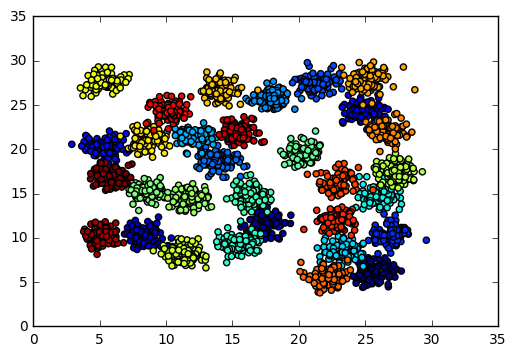

In [3]:
X, label, gt_K = load_dataset('./D31.txt')
plt.scatter(X[:, 0], X[:, 1], c=label)
plt.show()

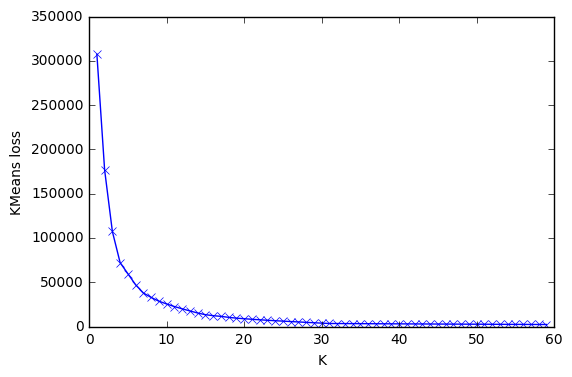

In [5]:
from sklearn.cluster import KMeans

loss = []
ks = range(1, 60, 1)
for k in ks:
    kmeans = KMeans(n_clusters=k, n_jobs=1)
    kmeans.fit(X)
    loss.append(kmeans.inertia_)
    
plt.plot(ks, loss, 'x-')
plt.xlabel("K")
plt.ylabel("KMeans loss")
plt.show()

## 3. Elbow Method

In the above example, loss curve drops signficantly when K is small. But when K is getting larger and larger, the drop rate is getting slower. This means that a small number of K can explained most information in this dataset. The Eblow Method is to find the "elbow" of the above curve. Adding cluster number in the left part of "eblow" can continously explained information, while in the right part of it may over explained the information.

In the above example, I choose the elbow point $K=20$. The clustering result is show as below.

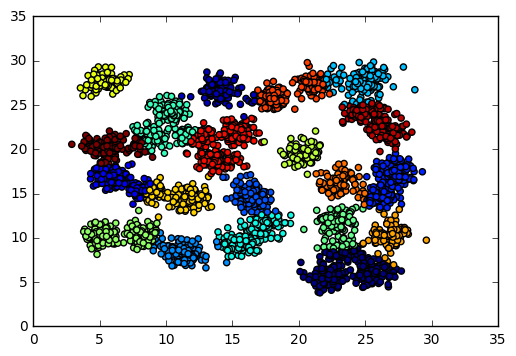

In [6]:
kmeans = KMeans(n_clusters=20, n_jobs=-1)
kmeans.fit(X)
p_label = kmeans.labels_

plt.scatter(X[:, 0], X[:, 1], c=p_label)
plt.show()

## 4. BIC

Bayesian information criterion (BIC) is a criterion for model selection. It considers the balance between model capacity and number of free parameters. The model with lowest BIC score is preferred. Its formal formulation is defined as
$$ BIC(X; \theta) = -2 ln(L(X; \theta)) + g(\theta) ln(N) $$
where 
* $\theta$, the model parameters
* $L(X; \theta) = \Pi_{i=1}^N p(x_i; \theta)$, maximum likelihood value of this model when fitting data $X$
* $g(\theta)$, number of model free parameters

To make BIC fitted in KMeans, we follow the procedure in XMeans (https://www.cs.cmu.edu/~dpelleg/download/xmeans.pdf). Some assumptions under this method is:
1. Every node is sampled from a multinoulli distribution, node $x_i$ belongs to cluster j probability is $$p(C^{(i)}=j | x_i, \theta) = p_j $$
where $C^{(i)}$ is the cluster assigned to $x_i$ and $|C_j|$ is number of nodes in cluster j.
2. Cluster j is defined as a multivariate gaussian distribution center at $\mu_j$ and with covariance $\sigma^2 I$.
The point $x_i$ in cluster j probability is
$$p(x_i|C^{(i)}=j, \theta) = \frac{1}{ (2\pi{\sigma}^2)^{D/2} } exp(-\frac{ {\|x_i - \mu_j\|}^2 }{ 2\sigma^2})$$
where D is the dimension of space.

Model likelihood is
$$ \begin{aligned}
L(X, C; \theta) 
&= \Pi_{i=1}^N p(x_i, C^{(i)}; \theta) \\
&= \Pi_{i=1}^N p(C^{(i)} | x_i, \theta) p(x_i|C^{(i)}, \theta) \end{aligned} $$

By using maximum likelihood method and seting derivative $ \frac{ \partial{ L(X, C; \theta) } }{ \partial \theta }$ to zero, some parameters can be estimated
$$ \hat{p}_j = \frac{ |C_j| }{ N } $$
$$ \hat{\mu}_j = \frac{ \sum_{x_i \in C_j} x_i }{ \|C_j\| } $$
$$ \hat{\sigma}^2 = \frac{ \sum_i {\| x_i - \hat{\mu}_{C^{(i)}} \|}^2  }{ DN }$$

Substituding this formula into likelihood function, we can get
$$ \begin{aligned}
ln L(X, C; \theta) 
&= \sum_{i=1}^N [ ln( p(C^{(i)} | x_i, \theta) ) + ln( p(x_i|C^{(i)}, \theta) ) ] \\
&= \sum_{i=1}^N [ ln( \frac{ C_{(i)} }{ N } ) - \frac{D}{2}ln(2\pi\hat{\sigma}^2) - \frac{ {\| x_i - \hat{\mu}_{C^{(i)}} \|}^2 }{ 2 \hat{\sigma}^2 } ] \\
&= \sum_{j=1}^{K} [C_{(j)} ln( \frac{ C_{(j)} }{ N } )] - \frac{ND}{2}ln(2\pi\hat{\sigma}^2) - \sum_{i=1}^{N} \frac{ {\| x_i - \hat{\mu}_{C^{(i)}} \|}^2 }{ 2 \hat{\sigma}^2 }
\end{aligned} $$

The number of free parameter in this model $g(\theta) = K(D + 1) $, which is consitude by 3 parts
* prior probability, K - 1 parameters
* cluster center $\mu_j$, KD parameters
* deviation $\sigma$ of gaussian distribution, 1 parameter

The BIC score of KMeans under this assumption is
$$ BIC(X; \theta) = -2\sum_{j=1}^{K} [C_{(j)} ln( \frac{ C_{(j)} }{ N } )] + NDln(2\pi\hat{\sigma}^2) + \sum_{i=1}^{N} \frac{ {\| x_i - \hat{\mu}_{C^{(i)}} \|}^2 }{ \hat{\sigma}^2 } + K(D + 1)ln(N) $$

In [2]:
def BIC(kmeans):
    D, N, K = kmeans.cluster_centers_.shape[1], len(kmeans.labels_), kmeans.n_clusters
    num_count = np.zeros(K, dtype=int)
    for label in kmeans.labels_:
        num_count[label] += 1
    sigma_square = kmeans.inertia_ / (D * N)
    
    bic = 0
    
    # first part
    for count in num_count:
        bic -= 2 * count * np.log(count * 1.0 / N)
    
    # second part
    bic += N*D * np.log(2 * np.pi * sigma_square)
    
    # third part
    bic += kmeans.inertia_ / (sigma_square)
    
    # fourth part
    bic += K * (D + 1) * np.log(N)
    
    return bic

It's time to draw the bic curve for KMeans

In [3]:
def calculate_bic(X, ks):
    bics = []
    best_k = 1
    best_bic = float('inf')
    best_kmeans = None

    for k in ks:
        kmeans = KMeans(n_clusters=k, n_jobs=-1)
        kmeans.fit(X)
        bic = BIC(kmeans)
        bics.append(bic)
    
        if bic < best_bic:
            best_k = k
            best_bic = bic
            best_kmeans = kmeans
            
    return bics, best_k, best_bic, best_kmeans

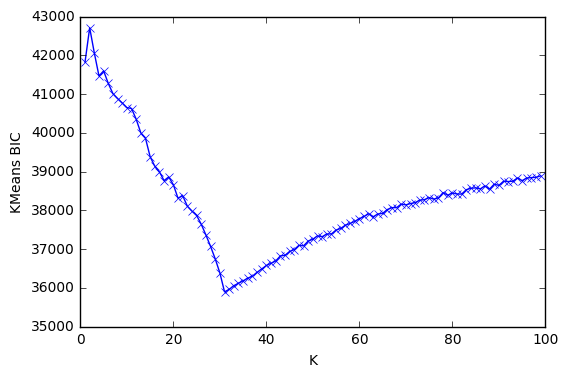

best number of k by BIC 31


In [10]:
ks = range(1, 100, 1)
bics, best_k, best_bic, best_kmeans = calculate_bic(X, ks)
plt.plot(ks, bics, 'x-')
plt.xlabel("K")
plt.ylabel("KMeans BIC")
plt.show()

print "best number of k by BIC", best_k

Clusters of the best model selected by BIC is plotted as below

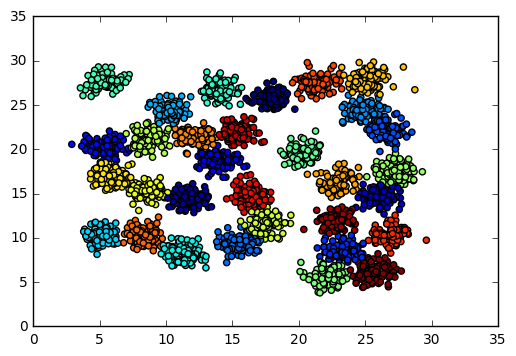

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=best_kmeans.labels_)
plt.show()

## 5. Other datasets

In the above experiment, we show the effectiveness of BIC. In this section, we repeat this experiment on other datasets.

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 10)

def search_and_draw(data_path):
    X, label, gt_K = load_dataset(data_path)
    ks = range(1, 100, 1)
    bics, best_k, best_bic, best_kmeans = calculate_bic(X, ks)

    plt.subplot(3, 1, 1)
    plt.plot(ks, bics, 'x-')
    plt.xlabel("K")
    plt.ylabel("KMeans BIC")

    plt.subplot(3, 1, 2)
    plt.scatter(X[:, 0], X[:, 1], c=label)
    plt.title('Original clustering Result (K %d)' % gt_K)

    plt.subplot(3, 1, 3)
    plt.scatter(X[:, 0], X[:, 1], c=best_kmeans.labels_)
    plt.title('Best BIC KMeans (K %d)' % best_k)

    plt.subplots_adjust(hspace=0.4)
    plt.show()

### 5.1 R15

N = 600, M = 15, D = 2

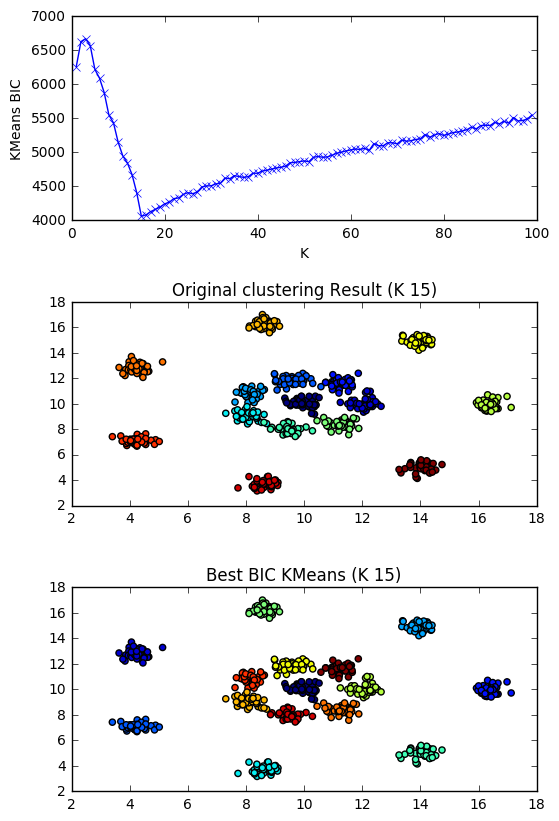

In [10]:
search_and_draw('./R15.txt')

### 5.2 Jain

N = 373, M = 2, D = 2 

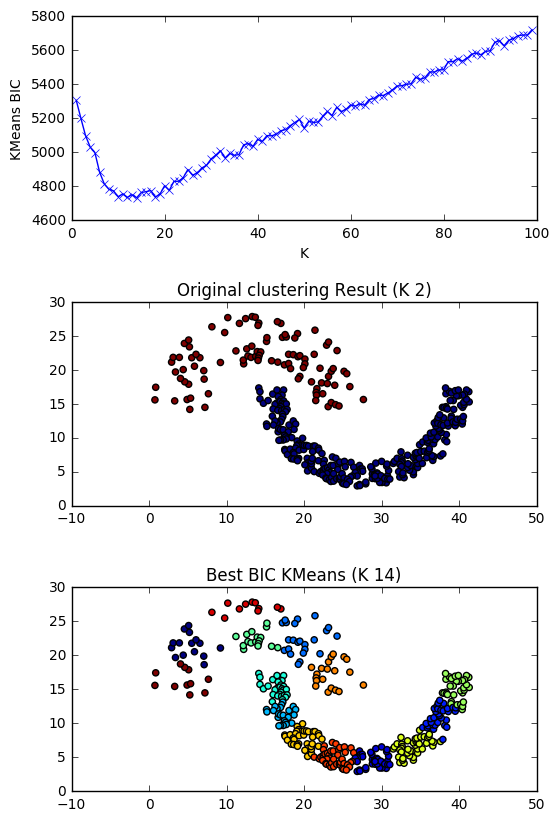

In [11]:
search_and_draw('./jain.txt')

### 5.3 Aggregation

N = 788, M = 7, D = 2 

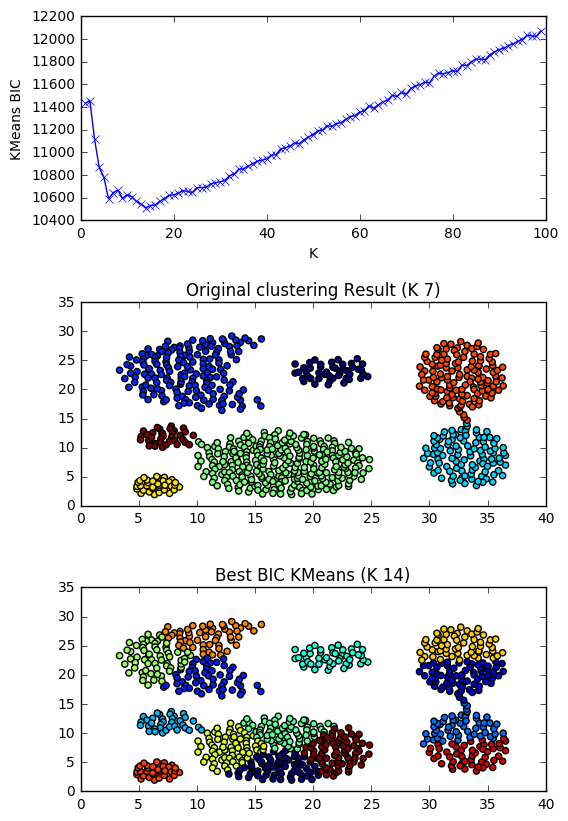

In [12]:
search_and_draw('./Aggregation.txt')

### 5.4 Compound

N = 399, M = 6, D = 2 

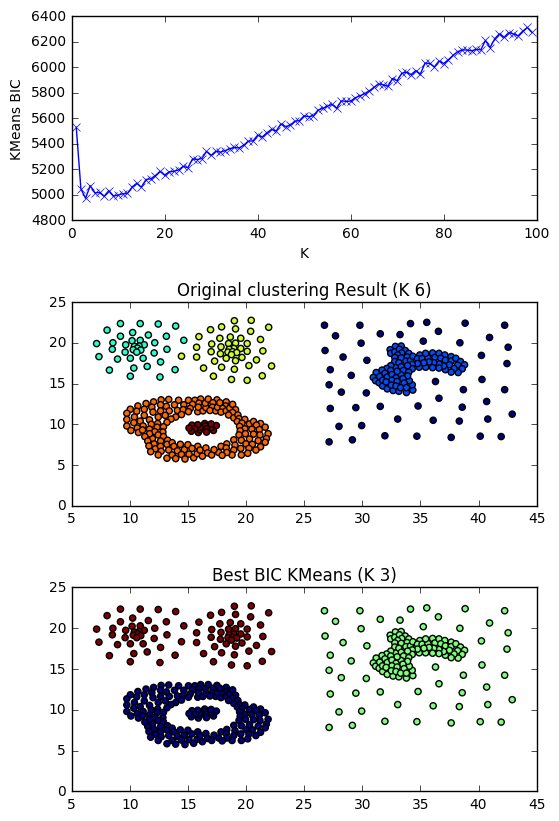

In [13]:
search_and_draw('./Compound.txt')

In the above experiment, we seen that BIC in KMeans can fit clusters like gaussian distribution very well. But it fails to other distribution.

## 6. Combine Hyperopt

We have seen that BIC can be a surrogate for evaluating clusters generated by KMeans. The lower the BIC score, the best the model it is. To save computation resources, we just want to get the best model BIC score and don't want to calculate every BIC under different value of K. Here, we adopt Hyperopt to search the parameter K. In order to make Hyperopt work, model loss under different hyper-parameters must be provided. In this case, it's just BIC.

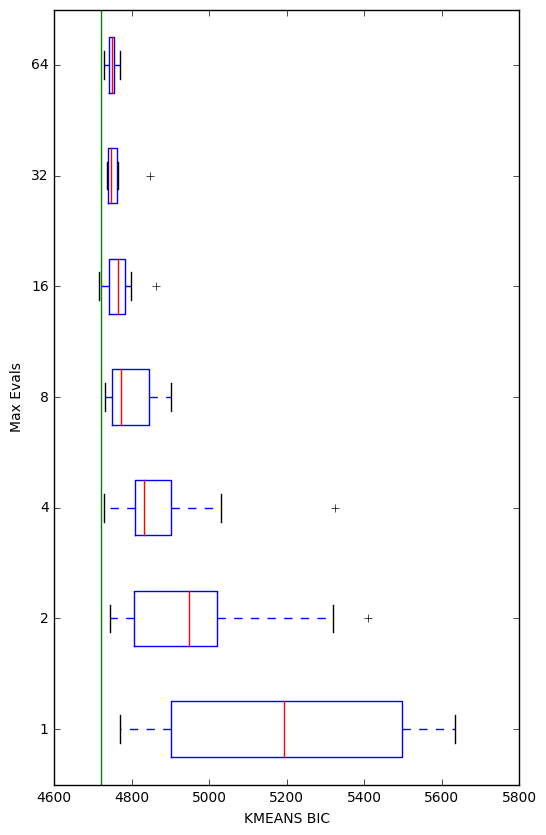

In [5]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.cluster import KMeans

X, label, gt_K = load_dataset('./jain.txt')

def objective(k):    
    kmeans = KMeans(n_clusters=k+1, n_jobs=-1)
    kmeans.fit(X)
    bic = BIC(kmeans)
    return bic

num_experiments = 7
num_repeat = 10
num_try_candicates = [pow(2,i) for i in range(num_experiments)]
result = []
for num_try in num_try_candicates:
    one_result = []
    for i_e in range(num_repeat):
        best = fmin(fn=objective,
            space=hp.randint('k', 98),
            algo=tpe.suggest,
            max_evals=num_try)
        one_result.append(objective(best['k']))
    result.append(one_result)
ks = range(1, 100, 1)
bics, best_k, best_bic, best_kmeans = calculate_bic(X, ks)
plt.figure()
plt.boxplot(x=result,vert=False,labels=num_try_candicates)
num_try_candicates.insert(0,0)
plt.plot([best_bic for i in range(num_experiments+1)],num_try_candicates,'g')
plt.ylabel("Max Evals")
plt.xlabel("KMEANS BIC")
plt.show()